Сравним все три метода кластеризации. Возьмем по 4 кластера.

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import os

Сделаем все три кластеризации, сделаем базовую предобработку, как и везде

In [2]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('Econom_Cities_data.csv', sep=';')

for col in ['Work', 'Price', 'Salary']:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)


df_no_outliers = df[(df['City'] != 'Cairo') & (df['City'] != 'Jakarta')].copy()

scaler = StandardScaler()

X_no_outliers = df_no_outliers[['Work', 'Price', 'Salary']].copy()
X_no_outliers[['Work', 'Price', 'Salary']] = scaler.fit_transform(X_no_outliers[['Work', 'Price', 'Salary']])

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

clusters = X_no_outliers.copy()
link = linkage(X_no_outliers, 'ward', 'euclidean')

clusters['hierarchical'] = fcluster(link, 4, criterion='maxclust')

In [4]:

from sklearn.cluster import KMeans


model = KMeans(n_clusters=4, random_state=42, max_iter=300, n_init=10, 
               verbose=0, tol=0.0001)
model.fit(X_no_outliers)

clusters['kmeans'] = model.labels_

In [5]:
from sklearn.cluster import DBSCAN


db_scan_improved = DBSCAN(eps=0.8, min_samples=2).fit(X_no_outliers)
clusters['dbscan'] = db_scan_improved.labels_

Используем метод понижения размерности. Сравним результаты

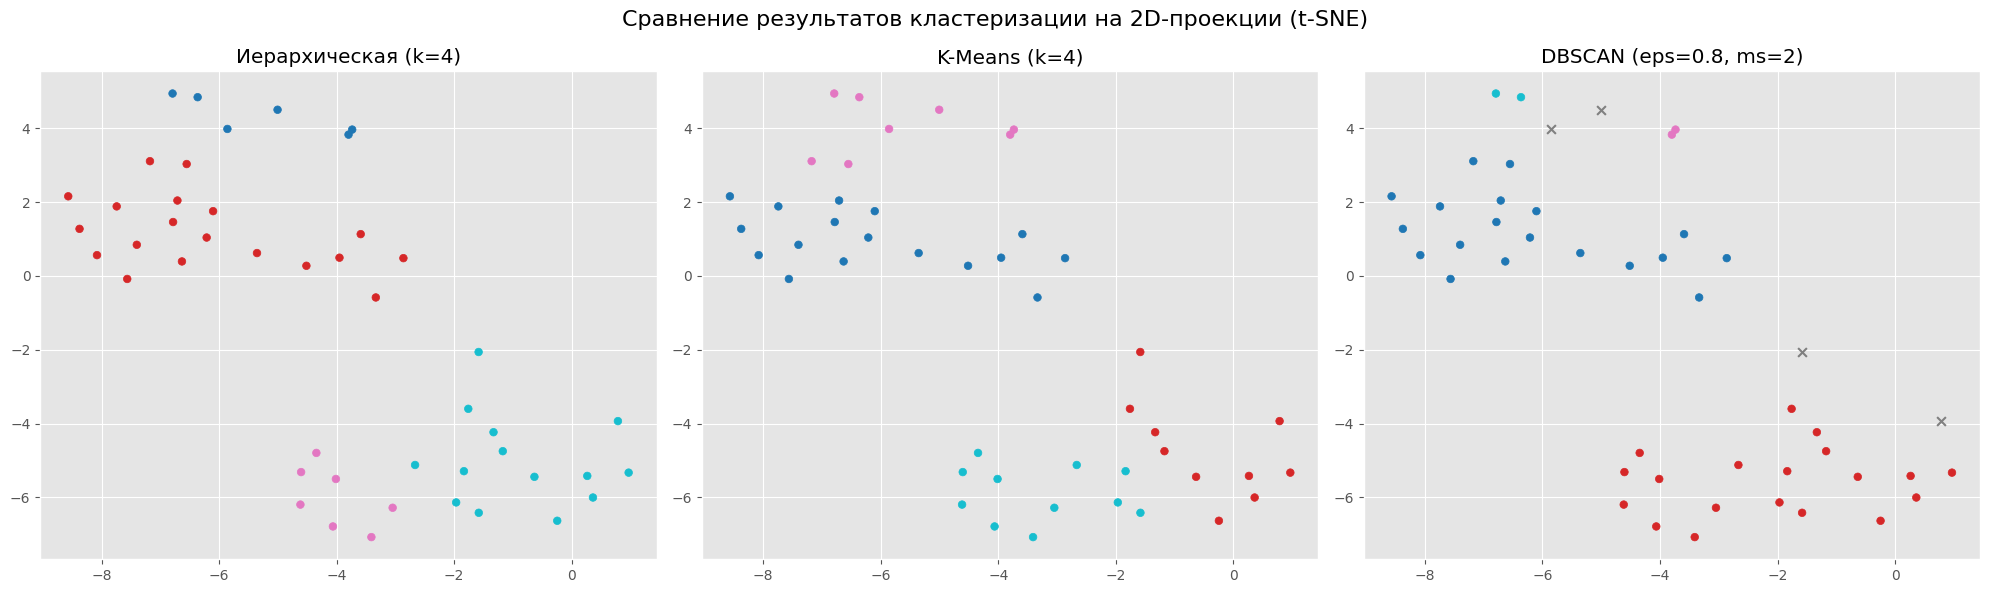

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

tsne = TSNE(n_components=2, perplexity=15, random_state=42, n_iter=1000)
X_2d = tsne.fit_transform(X_no_outliers)

plot_data = pd.DataFrame(X_2d, columns=['tsne_1', 'tsne_2'], index=X_no_outliers.index)
plot_data = pd.concat([plot_data, clusters[['hierarchical', 'kmeans', 'dbscan']]], axis=1)

methods = {
    'Иерархическая (k=4)': 'hierarchical',
    'K-Means (k=4)': 'kmeans',
    'DBSCAN (eps=0.8, ms=2)': 'dbscan'
}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Сравнение результатов кластеризации на 2D-проекции (t-SNE)', fontsize=16)

for i, (title, col) in enumerate(methods.items()):
    ax = axes[i]
    data = plot_data
    if col == 'dbscan':
        mask = data[col] != -1
        ax.scatter(data.loc[mask, 'tsne_1'], data.loc[mask, 'tsne_2'], c=data.loc[mask, col], cmap='tab10', s=30)
        ax.scatter(data.loc[~mask, 'tsne_1'], data.loc[~mask, 'tsne_2'], c='grey', marker='x', s=40, label='Шум (-1)')
    else:
        ax.scatter(data['tsne_1'], data['tsne_2'], c=data[col], cmap='tab10', s=30)
    ax.set_title(title)

plt.tight_layout()
plt.show()


Иерархическая кластеризация дает довольно похожие результаты с k-means при одинаковым количестве кластеров, разница буквально в 5-10 точках.

DBSCAN дает существенно отличающиеся результаты от двух других методов - появляются выбросы, а все точки, которые находятся близко, относятся к одному кластеру (на графиках видно две довольно плотные области) 
